# III - Modélisation : 

Le but de cette partie est de tenter d'obtenir des résultats pertinents et cohérents à l'aide d'un modèle bien choisie. On rappelle que notre travail se concentre sur un problème de classification binaire portant en tout sur 5 variables, les `radiéi`, $i \in \{1,2,3,4,5\}$, valant 1 si une entreprise a été radiée au cours de l'année i après la création, et 0 sinon. L'idée est la suivante :

Afin de prendre en compte les spécificité de chaque variables cibles, nous nous donnons 5 modèles sur lesquels l'entrainement se fera sur les data sets a priori pa rapport à `radiéi`.
C'est ainsi 5 prédictions que l'on obtiendra.
Nous aimerions disposer de probabilités de sortie pour la classe positive fiables, afin de construire potentiellement un score. Le choix d'un modèle de regression logistique est alors intérréssant. D'une part, ce modèle est simple et ne nécéssite que très peu de réglage d'hyperparamètres. D'autre part, les probabilités de sorties sont en règles générales les probabilités les moins biaisées parmi celles données par la classe des modèles de classification. 
Aussi, les paramètres de ce modèle sont directement interprétables grâce aux odd-ratios, choses qui pourrait peut-être nous être utiles dans une amélioration de ce travail.

C'est donc au total 5 regressions logistiques que l'on fera. Nous pourrons évaluer la pertinence de chaque variable grâce à une pénalisation l1. 

### Les métriques utiles pour l'évaluation des performances du modèle en lien avec notre problématique "métier" : 

Souvent en classification binaire, l'auc est la métrique de premier plan. Celle-çi correspond à l'air sous la courbe roc, courbe sur laquelle chaque point représente le couple (FN,TP) (TP == vrai positif / FN == faux négatif). Plus l'on se situe en haut à droite de cette courbe, c'est-à-dire au point $(0,1)$, plus le modèle discrimine bien les deux classes. L'idéal est donc d'obtenir comme courbe roc le carré unité, correspondant donc à un auc de 1. 
Nous regarderons donc attentivement cette métrique.

Mais ce n'est pas la seule que nous devons regarder. La précision, définie comme la proportion de vrais positives parmi les positifs prédit par le modèle pourrait aussi être regardée. Cependant, on peut partir du principe suivant concernant notre problème : on peut considérer que les personnes souhaitant savoir si leur projet d'entreprise pourrait connaitre une radiation, et de manière plus concrète pour une personne réelle, si leur projet d'entreprise pourrait connaitre un "échec", sont plutôt averse au risque, et que c'est d'ailleurs la raison qui les a poussé à faire appel à un tel outils. 
Par conséquent, si notre modèle prédit pour ces personnes que leur projet à des chances de ne pas "marcher", et que leur projet est de manière absolue un projet porteur d'avenir, qui ne connaitrait pas d'échec, cela est moins grave que le cas contraire, c'est-à-dire le cas où le modèle ne prédirait pas "d'échec", alors que le projet porte en soi l'échec.
En termes de métriques, si l'on s'accorde sur ce principe "métier", il est moins problématique d'avoir un certain nombre de faux positifs plutôt que d'avoir un certain nombre de faux négatifs. Autrement dit, il est plus important pour nous de porter regard au recall, définie que la proportion de positif effectivement prédit comme positif par le modèle, plutôt que de porter attention à la précision. 

Un bon moyen d'évaluer cela est regarder le score $f_\beta$, correspondant à une moyenne harmonique entre recall et précision dans le cas $\beta =1$, qui donne une importance de taille $\beta >0$ au recall (si $\beta <1$, la précision est favorisé). Pour notre problème, nous nous concentrerons sur $\beta \in \{2,3\}$, donnant ainsi plus d'important au recall.

### Le problème de sous-représentation de la classe positive dans nos données : 

Ce problème est natif de nos données : il reste tout de même assez rare qu'une entreprise soit radiée au cours des années suivant sa création. 
Ce déséquilibre est problématique pour un modèle de classification. Pour répondre à cela, plusieurs solutions existent. Une solution très utilisé en risque de crédit, par les banques notamment, faisant face à ce type de déséquilibre, est la technique Smote, consistant à ré-échantilloner le data set d'entrainement en favorisant artificiellement la classe pauvre. Une autre consiste à faire l'inverse, en sous-estimant artificiellement la classe riche.
Enfin, et c'est celle que nous utiliserons pour sa simplicité, les modèles de regression logistique implémentés par Sk-learn proposent de régler un paramètre "class_weights", permettant de donner plus ou moins d'importance aux classes désirées.

### Le problème d'un potentielle sur-apprentissage  : 

Afin de lutter contre cela, nous sélectionnerons les variables d'intérêts grâce au critère de pénalisation l1=1, donnant moins d'importance aux coefficients complexes. On éliminera les variables pour lesquelles les coefficients valent 0.

Concernant l'entrainement, nous pourrons procéder par cross-validation sur les data sets d'entrainement, en sélectionnant comme traditionnellement 5 strats.
Nous essairons plusieurs cross-validation selon les critères AUC, $f_2$ et $f_3$. L'évaluation finale se fera sur AUC et matrice de confusion.
Cependant par manque de temps, et par le fait que la computation est assez longue, nous n'utiliserons pas de cross-validation, et nous nous contenterons de la manière de procéder usuelle : entrainement sur le train, affinage des hyperparamétres sur l'évaluation, et constatation des performances sur le test. Ceci constituera l'un des principaux axes d'amélioration de cette partie.

### La prédiction, en pratique :

Comme nos variables vont nécessiter un certain pré-traitement afin de pouvoir fournir une prédiction, nous construirons un pipeline adapté.

---------

Le cadre étant posé, place à la pratique : 

In [1]:
from data.load_idf_10_24 import load_base_model, get_df_i
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, precision_score, fbeta_score
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import joblib

In [2]:
#Récupération des données issues de l'analyse depuis le module load_idf_10_24
data = load_base_model()

Data Frame idf_10_24MODEL récupéré depuis S3


In [3]:
#Correction des valeurs manquantes pour montantCapital à 0 et supression des doublons pour siren*
data["montantCapital"] = data["montantCapital"].apply(lambda x : 0 if x == "non-disp" else float(x))
data = data.drop_duplicates(subset=["siren"])

In [4]:
dfs = get_df_i(data)

In [5]:
#Sélections des variables candiates : 
var_cand = ["cp","taille_ville","mean_age","nb_associe","nb_local_concurrents",
"revCommune","sumxp","sumxp_rad","sumxp_ape","codeAPE","montantCapital","personneMorale","micro","revDep"]

In [6]:
#train-test-split pour chaque data frame | random_state = 0
var_cible = ["radié1","radié2","radié3","radié4","radié5"]

X_train = []
y_train = []
X_test = []
y_test = []
X_val = []
y_val = []
for df,var in zip(dfs,var_cible) : 
    X = df[var_cand]
    Y = df[var]

    x, x_t, y, y_t = train_test_split(X,Y,stratify=Y,test_size=0.15,random_state=0,shuffle=True)
    x_tr, x_v, y_tr ,y_v = train_test_split(x,y,stratify=y,test_size=0.15,random_state=0,shuffle=True)

    X_train.append(x_tr)
    X_test.append(x_t)
    X_val.append(x_v)
    y_train.append(y_tr)
    y_test.append(y_t)
    y_val.append(y_v)

In [7]:
    ############################################
# Définition du pipeline de pré-traitement #
    ############################################

colonnes_num = ["mean_age","nb_associe","nb_local_concurrents",
"revCommune","sumxp","sumxp_rad","sumxp_ape","montantCapital","revDep"]
colonnes_cat = ["cp","taille_ville","codeAPE","personneMorale","micro"]

#Pré-traitement pour standard scaler et transformation des cat en one hot
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colonnes_num),
        ('cat', OneHotEncoder(drop='first'), colonnes_cat)
    ]
)


In [ ]:
########################################### 
#         Définition des modèles          #
###########################################

models = (
    [Pipeline([
    ('preprocess', preprocess),
    ('logreg', LogisticRegression(
        l1_ratio=l1,
        solver='saga',
        max_iter=1000,
        class_weight="balanced",
    ))
]) for l1 in [0, 0.2, 0.5, 0.8, 1]])


In [ ]:
###########################################
#   Selection de modèle sur l1 selon f2   #
###########################################
f2_res = {  "radié1" : [],
            "radié2" : [],
            "radié3" : [],
            "radié4" : [],
            "radié5" : [],}

for x_tr,x_v,y_tr,y_v,var in zip(X_train,X_val,y_train,y_val,var_cible):
    for index in tqdm(range(5)):
        models[index].fit(x_tr,y_tr)
        y_pred = models[index].predict(y_val)
        f2 = fbeta_score(y_val,y_pred,beta=2)
        f2_res[var].append(f2)


0it [00:00, ?it/s]

In [315]:
num_cols = ["nb_local_concurrents","revCommune","mean_age","montantCapital","revDep","sumxp","sumxp_rad","sumxp_ape"]

X_trans = pd.get_dummies(X1)

X_trans[num_cols] = (X_trans[num_cols] - X_trans[num_cols].mean()) / X_trans[num_cols].std()

"""
train_obs = int(X_trans.shape[0]*0.8)
x_train = X_trans.iloc[0:train_obs,]
x_test = X_trans.iloc[train_obs:,]
y_train = y1[0:train_obs]
y_test = y1[train_obs:]
"""

x_train, x_test, y_train, y_test = train_test_split(X_trans, y1, test_size=0.2,shuffle=True,random_state=0)


In [317]:
model = LogisticRegression(random_state = 0,solver = "liblinear", max_iter = 500,class_weight="balanced")

In [318]:
model.fit(x_train,y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",0
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`

In [319]:
y_prob = model.predict_proba(x_test)[:,1]

In [320]:
#Selection du seuil optimal selon  
th = np.linspace(0,1,1000)
f2 = []

for i in th:
    y_pred = [1 if p >= i else 0 for p in y_prob]
    f2_it = fbeta_score(y_test,y_pred,beta=3)
    f2.append(f2_it)

max_index = f2.index(np.max(f2))
best_th = th[max_index]

In [321]:
print(best_th)

0.6446446446446447


In [322]:
y_pred = [1 if p >= best_th else 0 for p in y_prob]

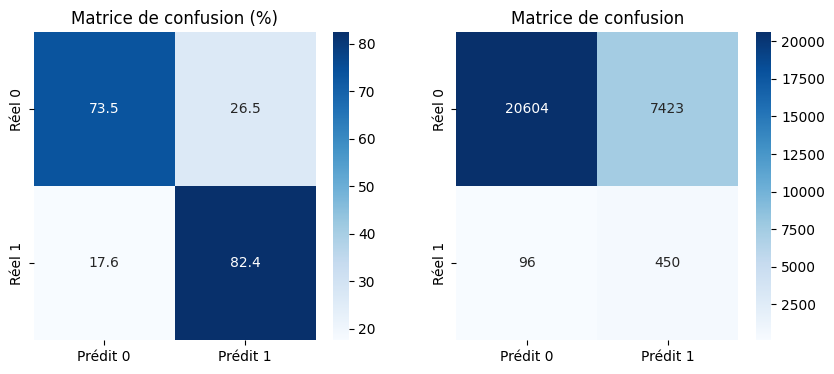

auc :  0.830781209014698
f1 :  0.10690105713267609
f3 :  0.2237247688177389
accuracy :  0.7368494732789697
precision :  0.05715737330115585
recall :  0.8241758241758241


In [323]:

# Création de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# y_true = vraies classes
# y_pred = prédictions du modèle
cm = confusion_matrix(y_test, y_pred)

cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100 

fig, ax = plt.subplots(1,2,figsize=(10,4))

sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=["Prédit 0", "Prédit 1"],
            yticklabels=["Réel 0", "Réel 1"], ax = ax[0])
ax[0].set_title("Matrice de confusion (%)")

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Prédit 0", "Prédit 1"],
            yticklabels=["Réel 0", "Réel 1"], ax = ax[1])
ax[1].set_title("Matrice de confusion")

plt.show()

print("auc : ", roc_auc_score(y_test,y_prob))
print("f1 : ", f1_score(y_test,y_pred))
print("f3 : ", fbeta_score(y_test,y_pred,beta=2))
print("accuracy : ", accuracy_score(y_test,y_pred))
print("precision : ", precision_score(y_test,y_pred))
print("recall : ", recall_score(y_test,y_pred))